In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import os 
warnings.filterwarnings('ignore') 

import numpy as np
from matplotlib import pyplot as plt 
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern, RBF
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

os.chdir("../../")

from src.algorithms import SubsetAlgorithm
from src.plotting import plot_algo_true_function
from src.models import MGPR
from scipy.io import loadmat
plt.style.use("mpl_style/matplotlib.rc")

## Writing an experimental goal as an algorithm

To begin, let's load data on a ternary phase diagram system of FeCoNi. Here, the X space (design space) consists of compositions c1, c2, c3; c3 = c1 + c2. Corresponding to each set of compositions are two magnetic property measurements: the Coercivity and the Kerr Rotation. Here X is the full discrete space and Y is the full measured property space. In a true sequential experiment, we would know which X to measure but Y would be unknown (i.e. the function of interest).

In [23]:
data = loadmat('datasets/FeCoNi_benchmark_dataset_220501a.mat')
X = data['C'][:,0:2] # only need 2 dimensions of composition since c3 = c2 + c1 
Y1 = data['Coer'] # magnetic property 1 
Y2 = data['Kerr'] # magnetic property 2 
Y = np.hstack((Y1, Y2))
n_features, n_properties = X.shape[1], Y.shape[1]

print("Size of the design space: {}, Size of the measured property space: {}".format(X.shape, Y.shape))

Size of the design space: (921, 2), Size of the measured property space: (921, 2)


To begin, we normalize X to between 0-1 for each of the compositions. We normalize Y to be between -1 and 1 for each of the properties. Note, here there is a question of how Y can be normalized when it is unknown (i.e. we shouldn't know the minimum or maximum values). In practice, the max and min values are obtained based on a user guess and can be approximate. 

In [24]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

scalers = [x_scaler, y_scaler]

X = x_scaler.fit_transform(X)
Y = y_scaler.fit_transform(Y)

X_unnorm, Y_unnorm = x_scaler.inverse_transform(X), y_scaler.inverse_transform(Y)


Let us consider the experimental goal of finding the set of materials (composition tuples) for which either the value for the Kerr Rotation is above the 90th percentile or the value for the Coercivity is above the 90th percentile. 

Note, there are 921 alloys in this dataset. This means that there will be between (0.1 * 921) and (2 * 0.1 * 921) alloys which statisfy this experimental goal. The former would correspond to the case where the top 10% w.r.t Kerr Rotation were the same alloys that achieved top 10% w.r.t Coercivity (i.e. intersection = 100%). The second case would be if the two conditions are disjoint.   

Now, let's turn to the task of writing this goal as an algorithm. Below we show the general structure of a SubsetAlgorithm. Each algorithm must implement a method named identify_subspace which takes in generic arguments x, y. The return from the algorithm are the set of ids corresponding to the x values which satisfy the goal. 

The algorithm below simply determines the 

In [30]:
class PercentileIntersection2D(SubsetAlgorithm):
    def __init__(self, scalers, percentile_list=[90, 90]):
        super().__init__(scalers)
        self.percentile_list = percentile_list

    def identify_subspace(self, x, y):
        x_unnorm, y_unnorm = super().unnormalize(x, y)
        percentile_threshold_p1 = np.percentile(y_unnorm[:, 0], self.percentile_list[0])
        percentile_threshold_p2 = np.percentile(y_unnorm[:, 1], self.percentile_list[1])

        ids1 = set(np.where(y_unnorm[:,0] >= percentile_threshold_p1)[0])
        ids2 = set(np.where(y_unnorm[:,1] >= percentile_threshold_p2)[0])

        return list(ids1.union(ids2))

Now, if Y were known, we could run our algorithm on Y to determine the set of X which achieve our goal. 

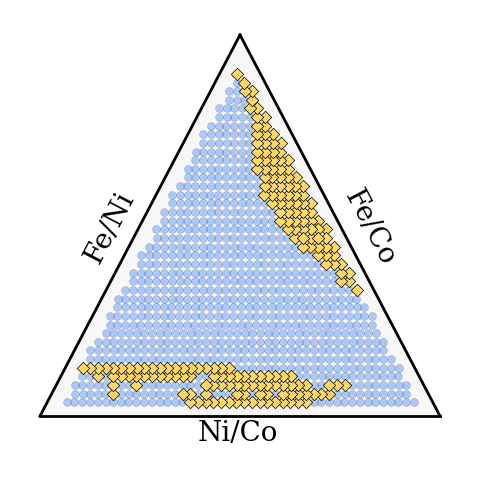

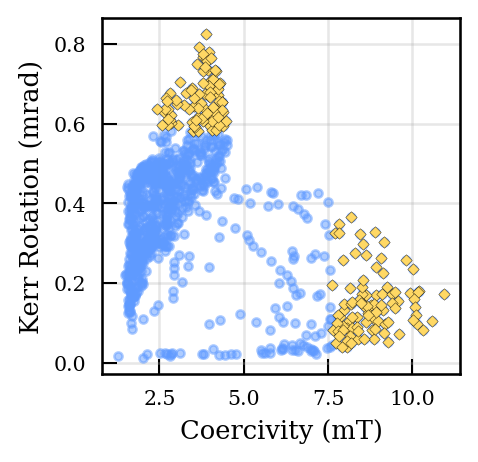

In [6]:
algorithm = PercentileIntersection2D(percentile_list=[90, 90], scalers=scalers)
target_subset_ids = algorithm.identify_subspace(X, Y)

plot_algo_true_function(algorithm, X_unnorm, Y_unnorm)

## Running an algorithm on the posterior mean or posterior samples from a Gaussian Process

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.975, random_state=42)
X_train.shape, y_train.shape

((23, 2), (23, 2))

In [8]:
kernel_initial = ConstantKernel(constant_value=1.0, constant_value_bounds=[0.01, 3.0]) * Matern(nu = 5/2, length_scale= n_features * [1.0], length_scale_bounds= n_features * [[0.01, 3.0]]) + WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')
kernel_initial_list = n_properties * [kernel_initial]

multi_gpr = MGPR(kernel_list=kernel_initial_list)

multi_gpr.fit(X_train, y_train)

In [9]:
posterior_mean, posterior_std = multi_gpr.predict(X)


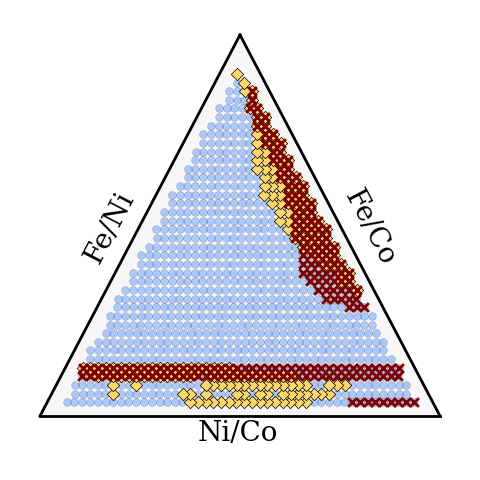

In [16]:
# algorithm = PercentileIntersection2D(percentile_list=[90, 90], scalers=scalers)
# posterior_mean_subset_ids = algorithm.identify_subspace(X, posterior_mean)
plot_algo_true_function(algorithm, X_unnorm, Y_unnorm, posterior_mean=posterior_mean, posterior_samples=None)

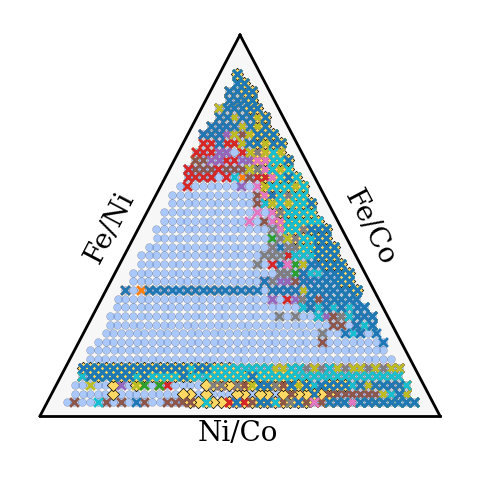

In [18]:
posterior_samples = multi_gpr.sample_y(X, n_samples = 20)
plot_algo_true_function(algorithm, X_unnorm, Y_unnorm, posterior_mean=None, posterior_samples=posterior_samples)